In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
session = tf.InteractiveSession()

In [3]:
mnist = input_data.read_data_sets("../data/MNIST", one_hot=True)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


# General parameters

In [4]:
width = 28
height = 28
flat = width * height
n_classes = 10

In [11]:
x = tf.placeholder(tf.float32, shape=[None, flat])
y = tf.placeholder(tf.float32, shape=[None, n_classes])

# Transform input into image tensor
x_image = tf.reshape(x, [-1, height, width, 1])

# Weights

In [12]:
def init_weights(shape):
    w_init = tf.truncated_normal(shape, dtype=tf.float32, stddev=0.5)
    return tf.Variable(w_init)

In [13]:
def init_bias(shape):
    bias_init = tf.constant(0.1, shape=shape)
    return tf.Variable(bias_init)

# 2D Convolution

In [14]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

# Max Pooling

In [34]:
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# Architecture

## Conv Layer 1

In [35]:
# Convolution 1: 3x3 kernels, 1 input channel, 32 feature maps
kernel_1 = init_weights([3, 3, 1, 32])
bias_1 = init_bias([32])
conv_1 = conv2d(x_image, kernel_1) + bias_1
conv_1

<tf.Tensor 'add_4:0' shape=(?, 28, 28, 32) dtype=float32>

In [36]:
# ReLU (conv 1)
conv_1_a = tf.nn.relu(conv_1)
conv_1_a

<tf.Tensor 'Relu_4:0' shape=(?, 28, 28, 32) dtype=float32>

In [37]:
# Max pooling (conv 1)
max_pool_1 = max_pool_2x2(conv_1_a)
max_pool_1

<tf.Tensor 'MaxPool_3:0' shape=(?, 14, 14, 32) dtype=float32>

In [38]:
# Finished layer 1
layer_1 = max_pool_1

## Conv Layer 2

In [39]:
# Convolution 2: 3x3 kernels, 32 input channel, 64 feature maps
kernel_2 = init_weights([3, 3, 32, 64])
bias_2 = init_bias([64])
conv_2 = conv2d(layer_1, kernel_2) + bias_2
conv_2

<tf.Tensor 'add_5:0' shape=(?, 14, 14, 64) dtype=float32>

In [40]:
# ReLU (conv 2)
conv_2_a = tf.nn.relu(conv_2)
conv_2_a

<tf.Tensor 'Relu_5:0' shape=(?, 14, 14, 64) dtype=float32>

In [41]:
# Max pooling (conv 2)
max_pool_2 = max_pool_2x2(conv_2_a)
max_pool_2

<tf.Tensor 'MaxPool_4:0' shape=(?, 7, 7, 64) dtype=float32>

In [42]:
# Finished layer 1
layer_2 = max_pool_2

## Fully Connected Layer

In [47]:
img_height, img_width, feature_maps = layer_2.get_shape().as_list()[1:]

In [50]:
# Flatten image
flat_units = img_height * img_width * feature_maps
flat_image = tf.reshape(layer_2, [-1, flat_units])
flat_image

<tf.Tensor 'Reshape_3:0' shape=(?, 3136) dtype=float32>

In [53]:
kernel_3 = init_weights([flat_units, 1024])
bias_3 = init_bias([1024])
fcn_1 = tf.matmul(flat_image, kernel_3) + bias_3
fcn_1

<tf.Tensor 'add_7:0' shape=(?, 1024) dtype=float32>

In [54]:
# ReLU (conv 2)
fcn_1_a = tf.nn.relu(fcn_1)
fcn_1_a

<tf.Tensor 'Relu_7:0' shape=(?, 1024) dtype=float32>

In [57]:
# Dropout
keep_prob = tf.placeholder(dtype=tf.float32)
fcn_1_drop = tf.nn.dropout(fcn_1_a, keep_prob=keep_prob)
fcn_1_drop

<tf.Tensor 'dropout_1/mul:0' shape=(?, 1024) dtype=float32>

In [55]:
# Finished layer 3
layer_3 = fcn_1_drop

## Softmax

In [59]:
kernel_4 = init_weights([1024, n_classes])
bias_4 = init_bias([n_classes])
pre_softmax = tf.matmul(fcn_1_drop, kernel_4) + bias_4
pre_softmax

<tf.Tensor 'add_8:0' shape=(?, 10) dtype=float32>

In [60]:
softmax = tf.nn.softmax(pre_softmax)
softmax

<tf.Tensor 'Softmax:0' shape=(?, 10) dtype=float32>

# Train configuration

In [79]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pre_softmax, labels=y))
loss

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

In [80]:
correct_predictions = tf.equal(tf.arg_max(softmax, dimension=1), tf.arg_max(y, dimension=1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

In [94]:
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

In [99]:
# Initialize variables
batch_size = 100
iterations = 2000
session.run(tf.global_variables_initializer())
train_losses = []
val_losses = []

In [100]:
start = time.time()
for i in range(iterations):        
    batch = mnist.train.next_batch(batch_size)
    train_dict = {
        x: batch[0],
        y: batch[1],
        keep_prob: 0.8
    }
    session.run(train_step, feed_dict=train_dict)
    # Evaluate train loss
    train_loss = loss.eval(feed_dict=train_dict)
    train_losses.append(train_loss)
    
    # Evaluate validation loss
    if i % 50 == 0:
        val_loss = loss.eval(feed_dict={
            x: mnist.validation.images,
            y: mnist.validation.labels,
            keep_prob: 1.0
        })
        val_losses.append(val_loss)
        print('[{:.2%}] Validation loss: {:.3f}'.format(i / iterations, val_loss))
        
end = time.time()
print('Training time: {:.2f} s'.format(end - start))

[0.00%] Validation loss: 695.941
[2.50%] Validation loss: 25.753
[5.00%] Validation loss: 12.167
[7.50%] Validation loss: 9.331
[10.00%] Validation loss: 5.484
[12.50%] Validation loss: 3.468
[15.00%] Validation loss: 2.621
[17.50%] Validation loss: 2.425
[20.00%] Validation loss: 2.325
[22.50%] Validation loss: 2.304
[25.00%] Validation loss: 2.094
[27.50%] Validation loss: 2.083
[30.00%] Validation loss: 2.387
[32.50%] Validation loss: 2.051
[35.00%] Validation loss: 1.968
[37.50%] Validation loss: 1.955
[40.00%] Validation loss: 1.994
[42.50%] Validation loss: 1.918
[45.00%] Validation loss: 1.932
[47.50%] Validation loss: 1.874
[50.00%] Validation loss: 1.940
[52.50%] Validation loss: 1.815
[55.00%] Validation loss: 1.856
[57.50%] Validation loss: 1.863
[60.00%] Validation loss: 1.794
[62.50%] Validation loss: 1.813
[65.00%] Validation loss: 1.773
[67.50%] Validation loss: 1.780
[70.00%] Validation loss: 1.747
[72.50%] Validation loss: 2.093
[75.00%] Validation loss: 1.798
[77.50%]

## Training plot

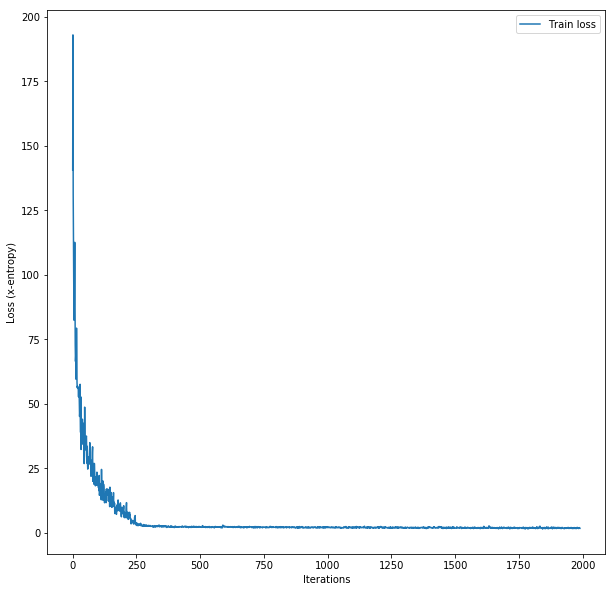

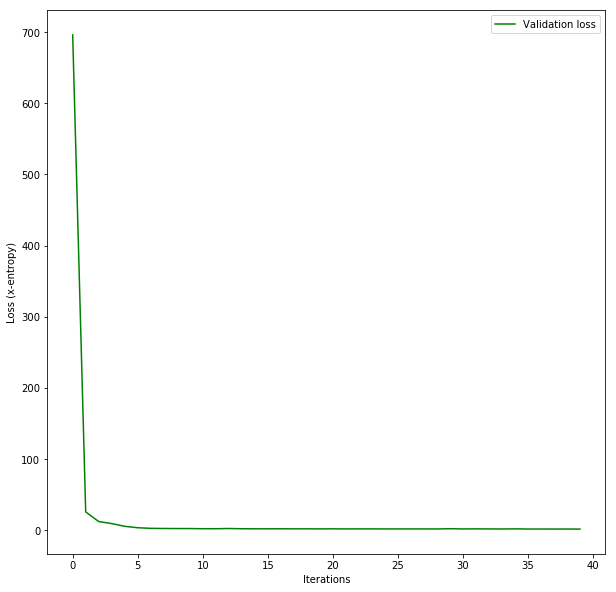

In [102]:
plt.figure(figsize=(10, 10))
plt.plot(train_losses[10:], label='Train loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (x-entropy)')
plt.legend()

plt.figure(figsize=(10, 10))
plt.plot(val_losses, color='green', label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss (x-entropy)')
plt.legend()

# Test

In [103]:
acc = accuracy.eval(feed_dict={
    x: mnist.test.images,
    y: mnist.test.labels,
    keep_prob: 1
})

print('Test accuracy: {:.2%}'.format(acc))

Test accuracy: 49.79%
